### Samsung Electronics Stock Prediction Analysis
### Pytorch (BI-LSTM)

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pdr.get_data_yahoo('005930.KS', start='2015-01-01', end='2020-12-23')

In [3]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,26800.0,26540.0,26800.0,26600.0,8774950.0,257.958313
2015-01-05,26720.0,26260.0,26720.0,26660.0,10139500.0,258.540161
2015-01-06,26340.0,25760.0,26300.0,25900.0,15235500.0,251.169937
2015-01-07,26220.0,25640.0,25880.0,26140.0,14322750.0,253.497406
2015-01-08,26780.0,26200.0,26780.0,26280.0,14477600.0,254.855087
...,...,...,...,...,...,...
2020-12-17,73700.0,72600.0,73400.0,73300.0,24293214.0,73300.000000
2020-12-18,73700.0,73000.0,73300.0,73000.0,17613029.0,73000.000000
2020-12-21,73400.0,72000.0,73100.0,73000.0,20367355.0,73000.000000


In [4]:
data.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
window_len = 15

In [6]:
def window(data, win_length):
    xdata = []
    ydata = []
    for i in range(len(data)-win_length):
        _x = data[i:i+win_length,:]
        _y = data[i+win_length,[-1]] #next term last value
        xdata.append(_x)
        ydata.append(_y)
    return np.array(xdata), np.array(ydata)

In [7]:
scaler_1 = MinMaxScaler().fit(np.array(data.High).reshape(1,-1).T)
High_nu = scaler_1.transform(np.array(data.High).reshape(1,-1).T)

scaler_2 = MinMaxScaler().fit(np.array(data.Low).reshape(1,-1).T)
Low_nu = scaler_2.transform(np.array(data.Low).reshape(1,-1).T)

scaler_3 = MinMaxScaler().fit(np.array(data.Open).reshape(1,-1).T)
Open_nu = scaler_3.transform(np.array(data.Open).reshape(1,-1).T)

scaler_4 = MinMaxScaler().fit(np.array(data.Volume).reshape(1,-1).T)
Volume_nu = scaler_4.transform(np.array(data.Volume).reshape(1,-1).T)

scaler_5 = MinMaxScaler().fit(np.array(data.Close).reshape(1,-1).T)
Close_nu = scaler_5.transform(np.array(data.Close).reshape(1,-1).T)

fdata = np.concatenate([High_nu, Low_nu, Open_nu, Volume_nu, Close_nu], axis=1)

train_set = fdata[:round(len(fdata)*0.8)]
test_set = fdata[round(len(fdata)*0.8)-window_len:]

In [8]:
#make window 15days
train_xdata, train_ydata = window(train_set, window_len)
test_xdata, test_ydata = window(test_set, window_len)

train_xdata_t = torch.FloatTensor(train_xdata)
test_xdata_t = torch.FloatTensor(test_xdata)

train_ydata_t = torch.FloatTensor(train_ydata)
test_ydata_t = torch.FloatTensor(test_ydata)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
input_size = 5 #train_xdata_t.size(1)
hidden_size = 10
output = 1
layers = 3
lr = 0.01

In [11]:
class S_model(nn.Module):
    def __init__(self, input_size, hidden_size, output, layers):
        super(S_model, self).__init__()
        
        self.BILSTM = nn.LSTM(input_size, hidden_size, num_layers=layers,
                             batch_first=True, bias=True,
                              bidirectional=True)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.FC = nn.Linear(hidden_size*layers*2, output, bias=True)
        nn.init.kaiming_uniform_(self.FC.weight)
        
    def forward(self, x):
        x, (h_s,c_s) = self.BILSTM(x)
        y = self.FC(self.dropout(torch.cat([c_s[i,:,:] for i in range(c_s.shape[0])], dim=1)))
        
        return y

In [12]:
S_s = S_model(input_size, hidden_size, output, layers)

loss_f = nn.MSELoss()
optimi = optim.Adam(S_s.parameters(), lr)

In [13]:
epochs = 500
cal_loss = []

for i in range(epochs):
    
    optimi.zero_grad()
    
    hypothesis = S_s(train_xdata_t)
    
    loss = loss_f(hypothesis, train_ydata_t)
    
    loss.backward()
    
    optimi.step()
    
    if i % 100 ==0 :
        cal_loss.append(loss)
    
cal_loss

[tensor(0.7498, grad_fn=<MseLossBackward>),
 tensor(0.0045, grad_fn=<MseLossBackward>),
 tensor(0.0022, grad_fn=<MseLossBackward>),
 tensor(0.0016, grad_fn=<MseLossBackward>),
 tensor(0.0014, grad_fn=<MseLossBackward>)]

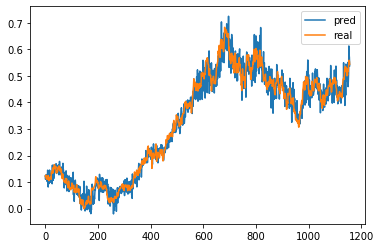

In [52]:
#500
plt.plot(S_s(train_xdata_t).detach().numpy())
plt.plot(train_ydata_t.detach().numpy())
plt.legend(['pred','real'])
plt.show()

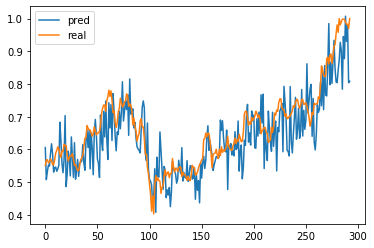

In [51]:
#500
plt.plot(S_s(test_xdata_t).detach().numpy())
plt.plot(test_ydata_t.detach().numpy())
plt.legend(['pred','real'])
plt.show()

In [16]:
def RMSE(y,y_pred):
    rmse = np.sqrt(mean_squared_error(y,y_pred))
    return rmse

In [69]:
#epochs=500 train_rmse
RMSE(train_ydata_t.detach().numpy(),S_s(train_xdata_t).detach().numpy())

0.03515061

In [18]:
#epochs=500 test_rmse
RMSE(test_ydata_t.detach().numpy(),S_s(test_xdata_t).detach().numpy())

0.06539559

### Plan : Real value compare (Hint : inverse)